<a href="https://colab.research.google.com/github/seongwoojang1123/Exploring-Key-Determinants-of-Halitosis-Through-a-Data-Analysis/blob/main/4_Model_Training_TEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost
!pip install pytorch_tabnet
!pip install numpy==1.23.5

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, roc_auc_score, classification_report,
                             confusion_matrix, roc_curve, f1_score, precision_score, recall_score)

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scipy.special import expit
from itertools import product

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# TabNet
from pytorch_tabnet.tab_model import TabNetClassifier

File Upload & Feature Select

In [2]:
file_path = "/content/drive/MyDrive/Halitosis/241121_Halitosis_data preprocessing.xlsx"
df = pd.read_excel(file_path)

features = [
       'Sex', 'Age', 'Xerostomia_subjective', 'UFR', 'SFR', 'O_Stomatitis', 'O_RAU', 'O_Candidiasis', 'O_Periodontitis', 'O_LichenPlanus', 'O_Sialodochitis', 'O_Glossodynia', 'O_BMS'
]
X = df[features].values
y = df["Halitosis_subjective"].values

ML Model Hiperparameter Tuning and Training

In [3]:
seed = 42
random.seed(seed)
np.random.seed(seed)

# XGBClassifier의 __sklearn_tags__ error removal__monkey patch
if not hasattr(XGBClassifier, "__sklearn_tags__"):
    XGBClassifier.__sklearn_tags__ = lambda self: {}

# Train/Validation/Test Split (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=seed, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=seed, stratify=y_temp
)
print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

# SMOTE (Only Trainung)
smote = SMOTE(random_state=seed)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("After SMOTE:", X_train_res.shape, y_train_res.shape)

# StandardScaler
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Train: (492, 13) (492,)
Validation: (164, 13) (164,)
Test: (165, 13) (165,)
After SMOTE: (824, 13) (824,)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:26:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:26:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:26:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:26:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:26:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.



Best XGBoost params (manual): {'objective': 'binary:logistic', 'eval_metric': 'auc', 'n_estimators': 27, 'max_depth': 5, 'learning_rate': 0.2, 'seed': 42} with AUC: 0.9420692362202917
Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:27:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best CatBoost params: {'depth': 7, 'iterations': 200, 'learning_rate': 0.1}
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best SVM params: {'C': 10, 'kernel': 'rbf'}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best RandomForest params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


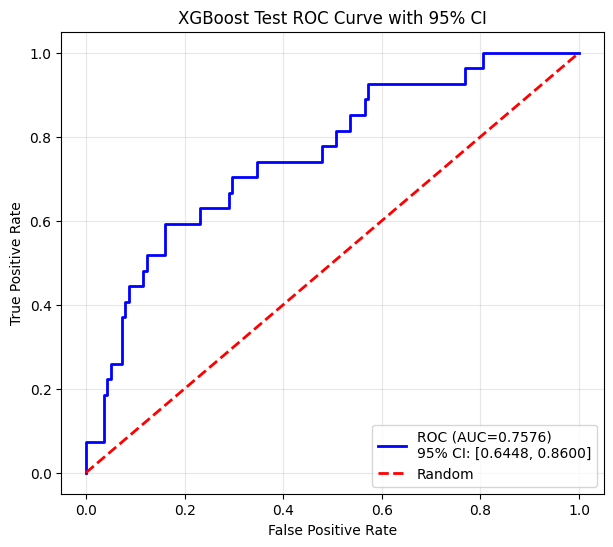

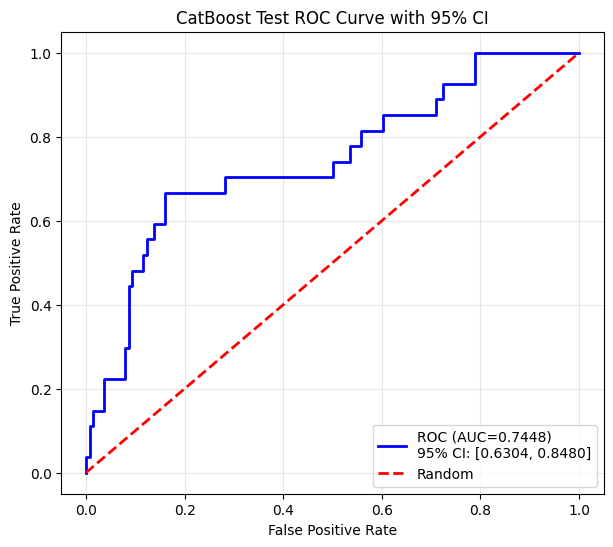

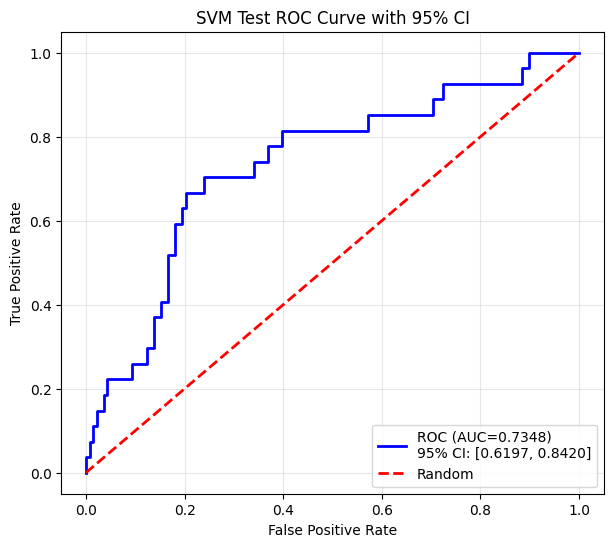

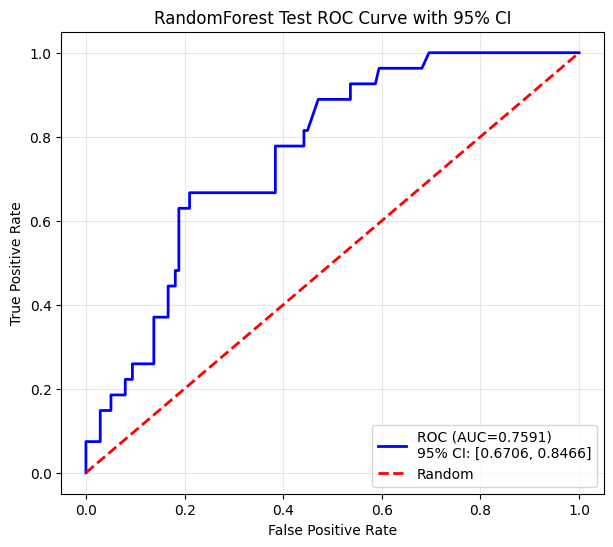

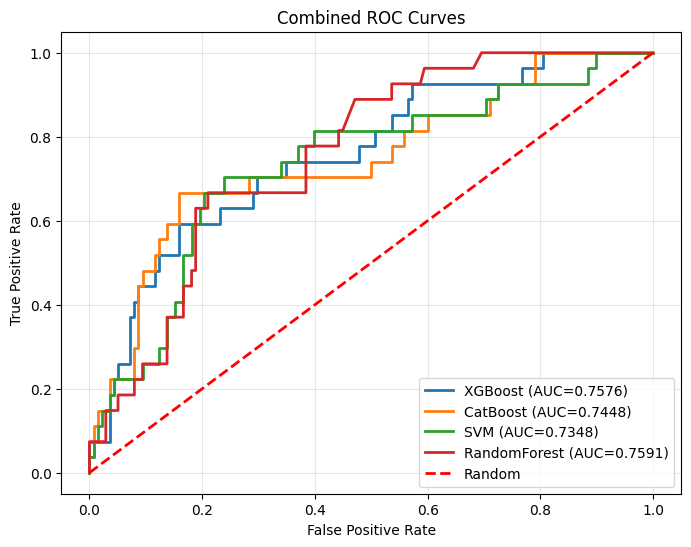


[XGBoost] Best threshold = 0.30, F1 = 0.4923


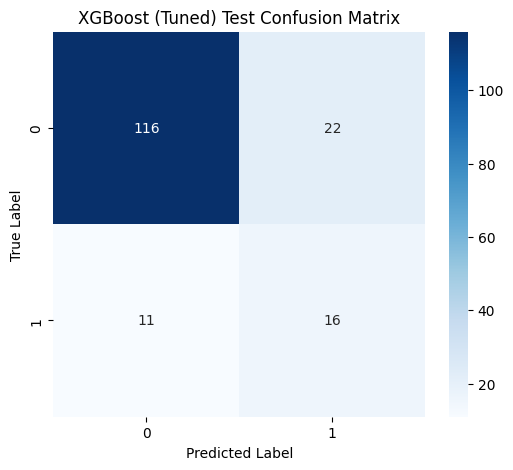

[XGBoost (Tuned)] Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.88       138
           1       0.42      0.59      0.49        27

    accuracy                           0.80       165
   macro avg       0.67      0.72      0.68       165
weighted avg       0.83      0.80      0.81       165


[CatBoost] Best threshold = 0.21, F1 = 0.5294


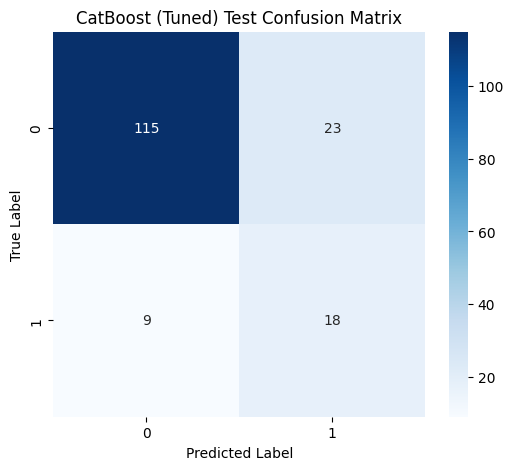

[CatBoost (Tuned)] Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.83      0.88       138
           1       0.44      0.67      0.53        27

    accuracy                           0.81       165
   macro avg       0.68      0.75      0.70       165
weighted avg       0.85      0.81      0.82       165


[SVM] Best threshold = 0.23, F1 = 0.4865


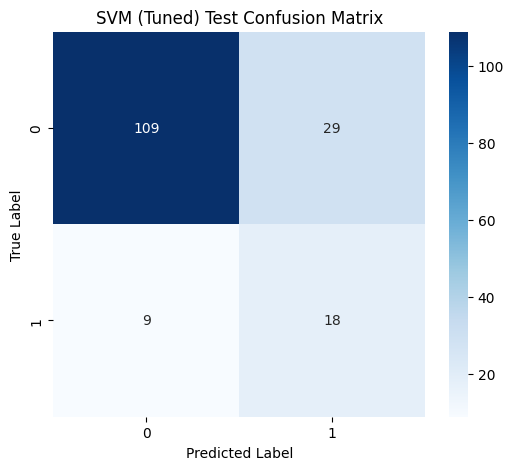

[SVM (Tuned)] Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       138
           1       0.38      0.67      0.49        27

    accuracy                           0.77       165
   macro avg       0.65      0.73      0.67       165
weighted avg       0.84      0.77      0.79       165


[RandomForest] Best threshold = 0.31, F1 = 0.4789


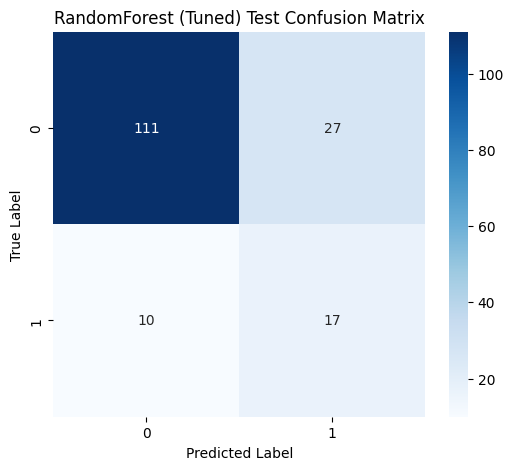

[RandomForest (Tuned)] Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.86       138
           1       0.39      0.63      0.48        27

    accuracy                           0.78       165
   macro avg       0.65      0.72      0.67       165
weighted avg       0.83      0.78      0.80       165



In [4]:
#  XGBoost Manual Grid Search (GridSearchCV Replace)

def manual_grid_search_xgb(X, y, param_grid, num_boost_round=1000,
                           cv=3, early_stopping_rounds=10, seed=42):
    best_score = 0
    best_params = None
    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for learning_rate in param_grid['learning_rate']:
                params = {
                    'objective': 'binary:logistic',
                    'eval_metric': 'auc',
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'learning_rate': learning_rate,
                    'seed': seed,
                }
                dtrain = xgb.DMatrix(X, label=y)
                cv_results = xgb.cv(
                    params,
                    dtrain,
                    num_boost_round=num_boost_round,
                    nfold=cv,
                    early_stopping_rounds=early_stopping_rounds,
                    seed=seed,
                    verbose_eval=False
                )
                current_auc = cv_results['test-auc-mean'].max()
                current_round = cv_results['test-auc-mean'].idxmax()
                if current_auc > best_score:
                    best_score = current_auc
                    best_params = params.copy()
                    best_params['n_estimators'] = current_round
    return best_params, best_score

xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
best_xgb_params, best_xgb_score = manual_grid_search_xgb(
    X_train_res, y_train_res, xgb_param_grid, seed=seed
)
print("Best XGBoost params (manual):", best_xgb_params, "with AUC:", best_xgb_score)

best_xgb = XGBClassifier(**best_xgb_params, random_state=seed, use_label_encoder=False)
best_xgb.fit(X_train_res, y_train_res)
xgb_pred_prob = best_xgb.predict_proba(X_test)[:, 1]

# CatBoost, SVM, RandomForest (GridSearchCV Use)

# (A) CatBoost
cat_param_grid = {
    'iterations': [50, 100, 200],
    'depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}
cat_model = CatBoostClassifier(random_state=seed, verbose=0)
cat_grid = GridSearchCV(
    cat_model, cat_param_grid,
    scoring='roc_auc', cv=3, n_jobs=-1, verbose=1
)
cat_grid.fit(X_train_res, y_train_res)
best_cat = cat_grid.best_estimator_
print("Best CatBoost params:", cat_grid.best_params_)
cat_pred_prob = best_cat.predict_proba(X_test)[:, 1]

# (B) SVM (SVC) – probability=True 필요
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}
svm_model = SVC(probability=True, random_state=seed)
svm_grid = GridSearchCV(
    svm_model, svm_param_grid,
    scoring='roc_auc', cv=3, n_jobs=-1, verbose=1
)
svm_grid.fit(X_train_res, y_train_res)
best_svm = svm_grid.best_estimator_
print("Best SVM params:", svm_grid.best_params_)
svm_pred_prob = best_svm.predict_proba(X_test)[:, 1]

# (C) RandomForest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
rf_model = RandomForestClassifier(random_state=seed)
rf_grid = GridSearchCV(
    rf_model, rf_param_grid,
    scoring='roc_auc', cv=3, n_jobs=-1, verbose=1
)
rf_grid.fit(X_train_res, y_train_res)
best_rf = rf_grid.best_estimator_
print("Best RandomForest params:", rf_grid.best_params_)
rf_pred_prob = best_rf.predict_proba(X_test)[:, 1]


# AUROC 95% CI calculation function via bootstrap

def bootstrap_auc_ci(y_true, y_pred_prob, n_bootstraps=1000, seed=42):
    rng = np.random.RandomState(seed)
    bootstrapped_scores = []
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_pred_prob), len(y_pred_prob))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_pred_prob[indices])
        bootstrapped_scores.append(score)
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    lower = sorted_scores[int(0.025 * len(sorted_scores))]
    upper = sorted_scores[int(0.975 * len(sorted_scores))]
    return lower, upper

# ROC Curve & Confusion Matrix

def plot_roc_curve(model_name, y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    auc_val = roc_auc_score(y_true, y_pred_prob)
    lower, upper = bootstrap_auc_ci(y_true, y_pred_prob, n_bootstraps=1000, seed=seed)
    plt.figure(figsize=(7,6))
    plt.plot(fpr, tpr, color='blue', lw=2,
             label=f'ROC (AUC={auc_val:.4f})\n95% CI: [{lower:.4f}, {upper:.4f}]')
    plt.plot([0,1], [0,1], color='red', lw=2, linestyle='--', label='Random')
    plt.title(f'{model_name} Test ROC Curve with 95% CI')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()

def plot_confusion_matrix(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Test Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Model ROC Curve

plot_roc_curve("XGBoost", y_test, xgb_pred_prob)
plot_roc_curve("CatBoost", y_test, cat_pred_prob)
plot_roc_curve("SVM", y_test, svm_pred_prob)
plot_roc_curve("RandomForest", y_test, rf_pred_prob)

plt.figure(figsize=(8,6))

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_pred_prob)
auc_xgb = roc_auc_score(y_test, xgb_pred_prob)
plt.plot(fpr_xgb, tpr_xgb, lw=2, label=f'XGBoost (AUC={auc_xgb:.4f})')

# CatBoost
fpr_cat, tpr_cat, _ = roc_curve(y_test, cat_pred_prob)
auc_cat = roc_auc_score(y_test, cat_pred_prob)
plt.plot(fpr_cat, tpr_cat, lw=2, label=f'CatBoost (AUC={auc_cat:.4f})')

# SVM
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_pred_prob)
auc_svm = roc_auc_score(y_test, svm_pred_prob)
plt.plot(fpr_svm, tpr_svm, lw=2, label=f'SVM (AUC={auc_svm:.4f})')

# RandomForest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_prob)
auc_rf = roc_auc_score(y_test, rf_pred_prob)
plt.plot(fpr_rf, tpr_rf, lw=2, label=f'RandomForest (AUC={auc_rf:.4f})')

plt.plot([0,1],[0,1], color='red', lw=2, linestyle='--', label='Random')
plt.title("Combined ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


# Threshold Tuning (F1 Score) & Confusion Matrix
# for each model: XGB, CatBoost, SVM, RandomForest

def find_best_threshold(y_true, pred_prob, step=0.01):
    thresholds = np.arange(0.0, 1.0 + step, step)
    best_th = 0.5
    best_f1 = 0.0
    for th in thresholds:
        pred_label = (pred_prob >= th).astype(int)
        cur_f1 = f1_score(y_true, pred_label)
        if cur_f1 > best_f1:
            best_f1 = cur_f1
            best_th = th
    return best_th, best_f1

### (A) XGBoost
xgb_best_th, xgb_best_f1 = find_best_threshold(y_test, xgb_pred_prob, step=0.01)
xgb_opt_pred = (xgb_pred_prob >= xgb_best_th).astype(int)

print(f"\n[XGBoost] Best threshold = {xgb_best_th:.2f}, F1 = {xgb_best_f1:.4f}")
plot_confusion_matrix("XGBoost (Tuned)", y_test, xgb_opt_pred)
print("[XGBoost (Tuned)] Classification Report:")
print(classification_report(y_test, xgb_opt_pred))

### (B) CatBoost
cat_best_th, cat_best_f1 = find_best_threshold(y_test, cat_pred_prob, step=0.01)
cat_opt_pred = (cat_pred_prob >= cat_best_th).astype(int)

print(f"\n[CatBoost] Best threshold = {cat_best_th:.2f}, F1 = {cat_best_f1:.4f}")
plot_confusion_matrix("CatBoost (Tuned)", y_test, cat_opt_pred)
print("[CatBoost (Tuned)] Classification Report:")
print(classification_report(y_test, cat_opt_pred))

### (C) SVM
svm_best_th, svm_best_f1 = find_best_threshold(y_test, svm_pred_prob, step=0.01)
svm_opt_pred = (svm_pred_prob >= svm_best_th).astype(int)

print(f"\n[SVM] Best threshold = {svm_best_th:.2f}, F1 = {svm_best_f1:.4f}")
plot_confusion_matrix("SVM (Tuned)", y_test, svm_opt_pred)
print("[SVM (Tuned)] Classification Report:")
print(classification_report(y_test, svm_opt_pred))

### (D) RandomForest
rf_best_th, rf_best_f1 = find_best_threshold(y_test, rf_pred_prob, step=0.01)
rf_opt_pred = (rf_pred_prob >= rf_best_th).astype(int)

print(f"\n[RandomForest] Best threshold = {rf_best_th:.2f}, F1 = {rf_best_f1:.4f}")
plot_confusion_matrix("RandomForest (Tuned)", y_test, rf_opt_pred)
print("[RandomForest (Tuned)] Classification Report:")
print(classification_report(y_test, rf_opt_pred))

NN Model Hiperparameter Tuning and Training

In [5]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Train/Validation/Test split (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=seed, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed, stratify=y_temp)
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

# SMOTE (Only Train)
smote = SMOTE(random_state=seed)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("After SMOTE:", X_train_res.shape, y_train_res.shape)

# StandardScaler (Train/Val/Test)
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Train set: (492, 13) (492,)
Validation set: (164, 13) (164,)
Test set: (165, 13) (165,)
After SMOTE: (824, 13) (824,)



--- Tuning Tab Transformer ---
Training with parameters: {'embed_dim': 16, 'num_heads': 2, 'num_layers': 2, 'dropout': 0.1}
Epoch 1/30 - Train Loss: 0.6627, Val Loss: 0.6472
Epoch 2/30 - Train Loss: 0.6136, Val Loss: 0.5835
Epoch 3/30 - Train Loss: 0.5703, Val Loss: 0.5488
Epoch 4/30 - Train Loss: 0.5338, Val Loss: 0.5383
Epoch 5/30 - Train Loss: 0.5175, Val Loss: 0.5381
Epoch 6/30 - Train Loss: 0.4949, Val Loss: 0.5251
Epoch 7/30 - Train Loss: 0.4722, Val Loss: 0.4929
Epoch 8/30 - Train Loss: 0.4692, Val Loss: 0.5246
Epoch 9/30 - Train Loss: 0.4471, Val Loss: 0.5197
Epoch 10/30 - Train Loss: 0.4561, Val Loss: 0.5236
Epoch 11/30 - Train Loss: 0.4394, Val Loss: 0.5067
Epoch 12/30 - Train Loss: 0.4223, Val Loss: 0.5256
Epoch 13/30 - Train Loss: 0.4175, Val Loss: 0.5113
Epoch 14/30 - Train Loss: 0.4229, Val Loss: 0.4950
Epoch 15/30 - Train Loss: 0.3985, Val Loss: 0.5249
Epoch 16/30 - Train Loss: 0.3913, Val Loss: 0.5397
Epoch 17/30 - Train Loss: 0.3998, Val Loss: 0.5251
Epoch 18/30 - Tra

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


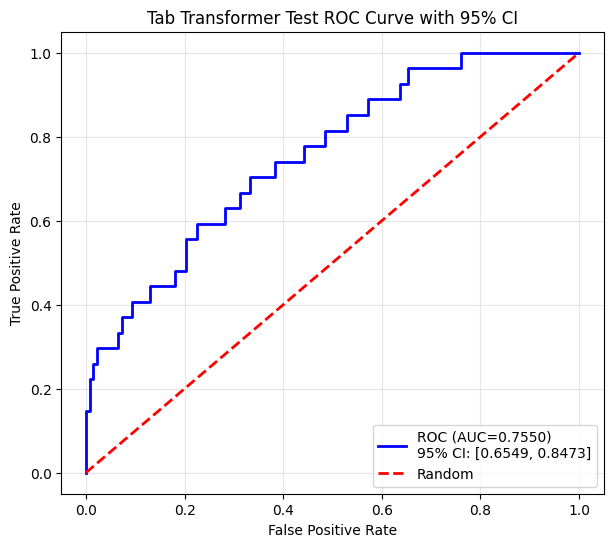

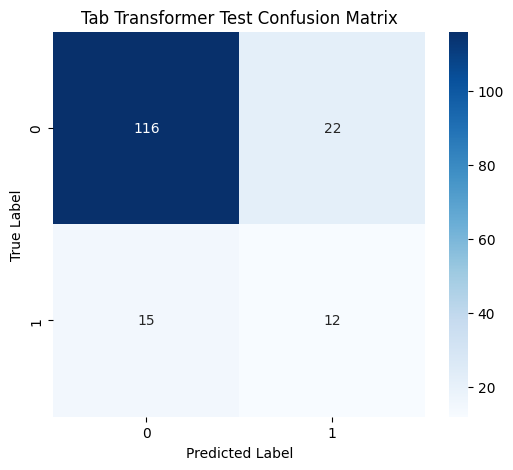

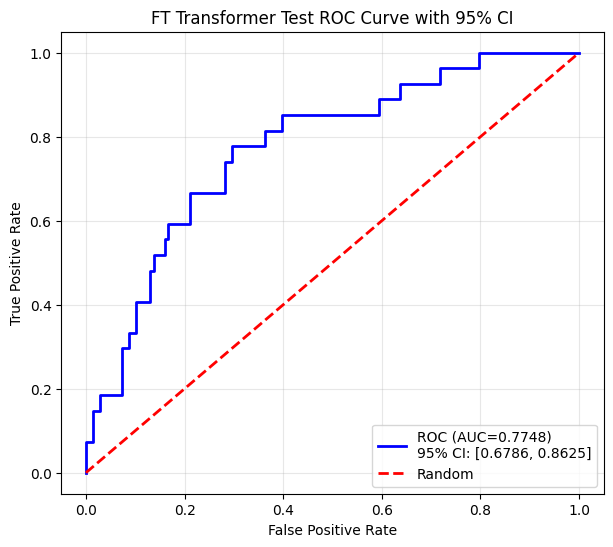

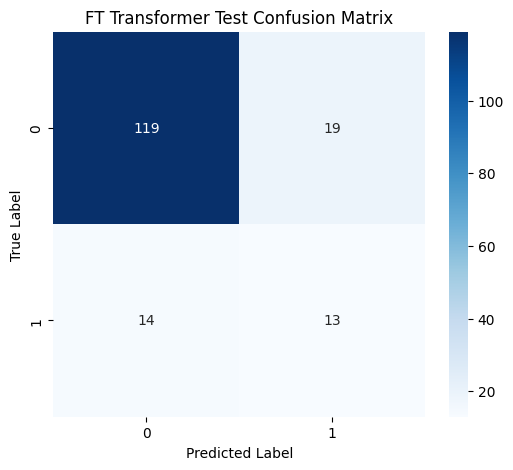

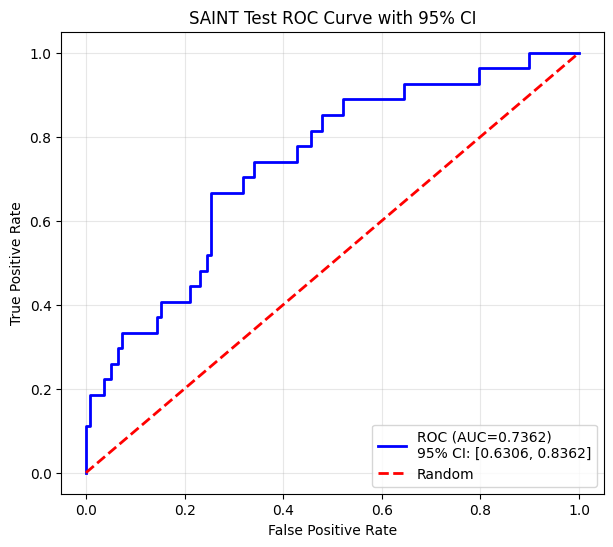

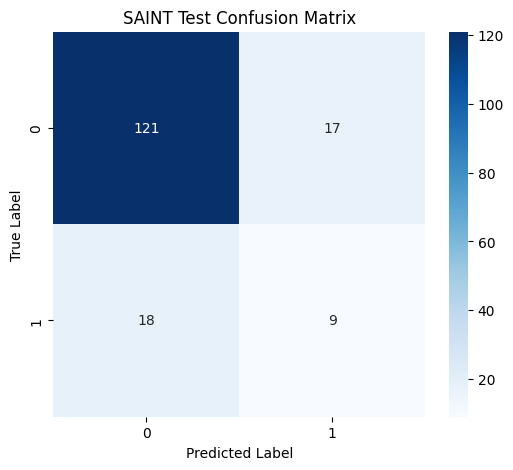

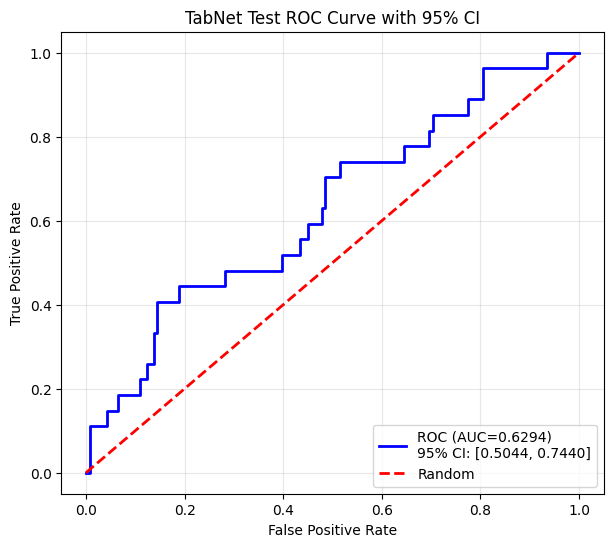

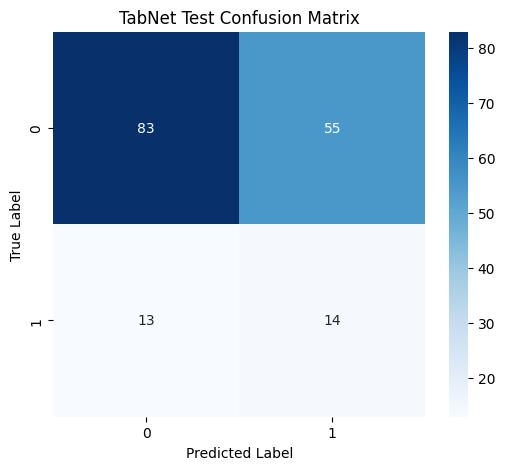

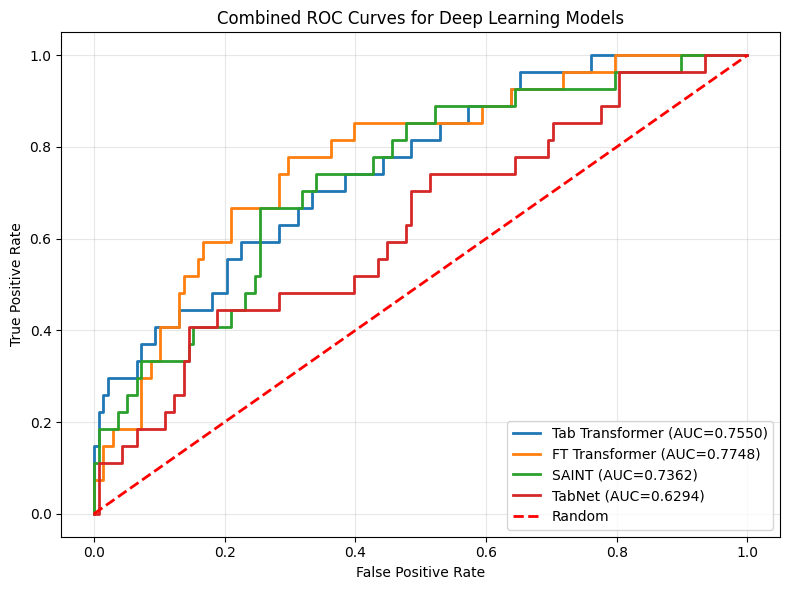

In [6]:
# PyTorch Tensor conversion
X_train_tensor = torch.tensor(X_train_res, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_res, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# (A) Tab Transformer (PyTorch)
class TabTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim=32, num_heads=4, num_layers=2, dropout=0.1):
        """
        간단한 Tab Transformer: 입력을 embed_dim으로 매핑한 후 Transformer Encoder 적용
        """
        super(TabTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads,
                                                    dim_feedforward=embed_dim*4, dropout=dropout,
                                                    batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, 1)
    def forward(self, x):
        x = self.embedding(x)           # (batch_size, embed_dim)
        x = x.unsqueeze(1)              # (batch_size, 1, embed_dim)
        x = self.transformer_encoder(x)
        x = x.squeeze(1)                # (batch_size, embed_dim)
        x = self.fc(x)                  # (batch_size, 1)
        return x

# (B) FT Transformer
class FTTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim=16, num_heads=2, num_layers=2, dropout=0.1):
        super(FTTransformer, self).__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, dropout=dropout,
                                                    batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        x = self.input_proj(x)
        x = x.unsqueeze(1)
        x = self.transformer_encoder(x)
        x = x.squeeze(1)
        x = self.fc(x)
        return x

# (C) SAINT
class SAINT(nn.Module):
    def __init__(self, input_dim, hidden_dim=16, num_heads=2, num_layers=2, dropout=0.1):
        super(SAINT, self).__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, dropout=dropout,
                                                    batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        x = self.input_proj(x)
        x = x.unsqueeze(1)
        x = self.transformer_encoder(x)
        x = x.squeeze(1)
        x = self.fc(x)
        return x

# (D) TabNet
tabnet_model = TabNetClassifier(verbose=0)

# Training

def train_deep_model(model, train_loader, val_loader, device, num_epochs=50):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float("inf")
    best_state = None
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                val_outputs = model(X_val_batch)
                total_val_loss += criterion(val_outputs, y_val_batch).item()
        avg_val_loss = total_val_loss / len(val_loader)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_state = model.state_dict()
    model.load_state_dict(best_state)
    return model

# Hiperparameter Tuning (simple Grid Search)

from itertools import product

def tune_deep_model(model_class, param_grid, train_loader, val_loader, device, num_epochs=50):
    """
    model_class: 튜닝할 모델 클래스 (예: TabTransformer)
    param_grid: dictionary 형태로 하이퍼파라미터 후보, 예) {'embed_dim': [16, 32], 'num_heads': [2, 4], 'dropout': [0.1, 0.3]}
    Returns: best_model, best_params, best_val_loss
    """
    best_val_loss = float("inf")
    best_params = None
    best_model = None
    keys = list(param_grid.keys())
    for values in product(*[param_grid[k] for k in keys]):
        params = dict(zip(keys, values))
        print("Training with parameters:", params)
        # instantiate the model with current parameters
        model = model_class(input_dim=X_train_tensor.shape[1], **params)
        # train the model
        model = train_deep_model(model, train_loader, val_loader, device, num_epochs=num_epochs)
        # evaluate on validation set
        model.eval()
        total_val_loss = 0
        criterion = nn.BCEWithLogitsLoss()
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                val_outputs = model(X_val_batch)
                total_val_loss += criterion(val_outputs, y_val_batch).item()
        avg_val_loss = total_val_loss / len(val_loader)
        print("Validation loss:", avg_val_loss)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_params = params
            best_model = model
    print("Best parameters:", best_params, "with validation loss:", best_val_loss)
    return best_model, best_params, best_val_loss

# Tab Transformer
tabtrans_param_grid = {
    'embed_dim': [16, 32],
    'num_heads': [2, 4],
    'num_layers': [2],
    'dropout': [0.1, 0.3]
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\n--- Tuning Tab Transformer ---")
best_tabtrans_model, best_tabtrans_params, best_tabtrans_loss = tune_deep_model(TabTransformer, tabtrans_param_grid, train_loader, val_loader, device, num_epochs=30)

# (B) FT Transformer
fttrans_param_grid = {
    'hidden_dim': [16, 32],
    'num_heads': [2, 4],
    'num_layers': [2],
    'dropout': [0.1, 0.3]
}
print("\n--- Tuning FT Transformer ---")
best_fttrans_model, best_fttrans_params, best_fttrans_loss = tune_deep_model(FTTransformer, fttrans_param_grid, train_loader, val_loader, device, num_epochs=30)

# (C) SAINT
saint_param_grid = {
    'hidden_dim': [16, 32],
    'num_heads': [2, 4],
    'num_layers': [2],
    'dropout': [0.1, 0.3]
}
print("\n--- Tuning SAINT ---")
best_saint_model, best_saint_params, best_saint_loss = tune_deep_model(SAINT, saint_param_grid, train_loader, val_loader, device, num_epochs=30)

# Evaluation

def get_deep_model_predictions(model, test_loader, device):
    model.eval()
    y_pred_prob = []
    with torch.no_grad():
        for X_batch, _ in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            y_pred_prob.extend(probs)
    y_pred_prob = np.array(y_pred_prob)
    y_pred = (y_pred_prob >= 0.5).astype(int)
    return y_pred_prob, y_pred

# (A) Tuning result: Tab Transformer
y_pred_prob_tabtrans, y_pred_tabtrans = get_deep_model_predictions(best_tabtrans_model, test_loader, device)

# (B) Tuning result: FT Transformer
y_pred_prob_ft, y_pred_ft = get_deep_model_predictions(best_fttrans_model, test_loader, device)

# (C) Tuning result: SAINT
y_pred_prob_saint, y_pred_saint = get_deep_model_predictions(best_saint_model, test_loader, device)

# (D) TabNet result
print("\n--- Training TabNet ---")
tabnet_model.fit(
    X_train_res, y_train_res,
    eval_set=[(X_val, y_val)],
    max_epochs=50,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)
y_pred_prob_tabnet = tabnet_model.predict_proba(X_test)[:, 1]
y_pred_tabnet = (y_pred_prob_tabnet >= 0.5).astype(int)

# ROC & Confusion Matrix visualization

def plot_roc_curve(model_name, y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    auc_val = roc_auc_score(y_true, y_pred_prob)
    lower, upper = bootstrap_auc_ci(y_true, y_pred_prob, n_bootstraps=1000, seed=seed)
    plt.figure(figsize=(7,6))
    plt.plot(fpr, tpr, color='blue', lw=2,
             label=f'ROC (AUC={auc_val:.4f})\n95% CI: [{lower:.4f}, {upper:.4f}]')
    plt.plot([0,1], [0,1], color='red', lw=2, linestyle='--', label='Random')
    plt.title(f'{model_name} Test ROC Curve with 95% CI')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()

def plot_confusion_matrix(model_name, y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Test Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


# Result visualization

# Tab Transformer
plot_roc_curve("Tab Transformer", y_test, y_pred_prob_tabtrans)
plot_confusion_matrix("Tab Transformer", y_test, y_pred_tabtrans)

# FT Transformer
plot_roc_curve("FT Transformer", y_test, y_pred_prob_ft)
plot_confusion_matrix("FT Transformer", y_test, y_pred_ft)

# SAINT
plot_roc_curve("SAINT", y_test, y_pred_prob_saint)
plot_confusion_matrix("SAINT", y_test, y_pred_saint)

# TabNet
plot_roc_curve("TabNet", y_test, y_pred_prob_tabnet)
plot_confusion_matrix("TabNet", y_test, y_pred_tabnet)

plt.figure(figsize=(8,6))

# Tab Transformer
fpr_tab, tpr_tab, _ = roc_curve(y_test, y_pred_prob_tabtrans)
auc_tab = roc_auc_score(y_test, y_pred_prob_tabtrans)
plt.plot(fpr_tab, tpr_tab, lw=2, label=f'Tab Transformer (AUC={auc_tab:.4f})')

# FT Transformer
fpr_ft, tpr_ft, _ = roc_curve(y_test, y_pred_prob_ft)
auc_ft = roc_auc_score(y_test, y_pred_prob_ft)
plt.plot(fpr_ft, tpr_ft, lw=2, label=f'FT Transformer (AUC={auc_ft:.4f})')

# SAINT
fpr_saint, tpr_saint, _ = roc_curve(y_test, y_pred_prob_saint)
auc_saint = roc_auc_score(y_test, y_pred_prob_saint)
plt.plot(fpr_saint, tpr_saint, lw=2, label=f'SAINT (AUC={auc_saint:.4f})')

# TabNet
fpr_tabnet, tpr_tabnet, _ = roc_curve(y_test, y_pred_prob_tabnet)
auc_tabnet = roc_auc_score(y_test, y_pred_prob_tabnet)
plt.plot(fpr_tabnet, tpr_tabnet, lw=2, label=f'TabNet (AUC={auc_tabnet:.4f})')

plt.plot([0,1], [0,1], color='red', lw=2, linestyle='--', label='Random')
plt.title("Combined ROC Curves for Deep Learning Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Stacking Ensemble

In [7]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# XGBClassifier의 __sklearn_tags__ error removal__monkey patch
if not hasattr(XGBClassifier, "__sklearn_tags__"):
    XGBClassifier.__sklearn_tags__ = lambda self: {}

# Train/Validation/Test Split (60/20/20)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=seed, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed, stratify=y_temp)
print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

# SMOTE (Only Train)
smote = SMOTE(random_state=seed)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("After SMOTE:", X_train_res.shape, y_train_res.shape)

# StandardScaler
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Train: (492, 13) (492,)
Validation: (164, 13) (164,)
Test: (165, 13) (165,)
After SMOTE: (824, 13) (824,)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:31:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:31:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:31:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:31:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:31:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.



Best XGBoost params (manual): {'objective': 'binary:logistic', 'eval_metric': 'auc', 'n_estimators': 27, 'max_depth': 5, 'learning_rate': 0.2, 'seed': 42} with AUC: 0.9420692362202917
Fitting 3 folds for each of 27 candidates, totalling 81 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:31:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best RandomForest params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}

--- Tuning Tab Transformer ---
Tuning with parameters: {'embed_dim': 32, 'num_heads': 2, 'num_layers': 2, 'dropout': 0.1}
Epoch 1/30 - Train Loss: 0.6545, Val Loss: 0.6954
Epoch 2/30 - Train Loss: 0.5744, Val Loss: 0.5942
Epoch 3/30 - Train Loss: 0.5406, Val Loss: 0.5878
Epoch 4/30 - Train Loss: 0.5105, Val Loss: 0.4639
Epoch 5/30 - Train Loss: 0.4856, Val Loss: 0.5030
Epoch 6/30 - Train Loss: 0.4697, Val Loss: 0.4699
Epoch 7/30 - Train Loss: 0.4478, Val Loss: 0.5006
Epoch 8/30 - Train Loss: 0.4401, Val Loss: 0.4956
Epoch 9/30 - Train Loss: 0.4068, Val Loss: 0.5681
Epoch 10/30 - Train Loss: 0.4001, Val Loss: 0.5274
Epoch 11/30 - Train Loss: 0.4019, Val Loss: 0.5283
Epoch 12/30 - Train Loss: 0.3715, Val Loss: 0.5747
Epoch 13/30 - Train Loss: 0.3635, Val Loss: 0.5572
Epoch 14/30 - Train Loss: 0.3688, Val Loss: 0.5486
Epoch 15/30 - Train Loss: 0.3499, Val Loss: 0.5861
Epoch 16/30 - Train Loss: 0.3575

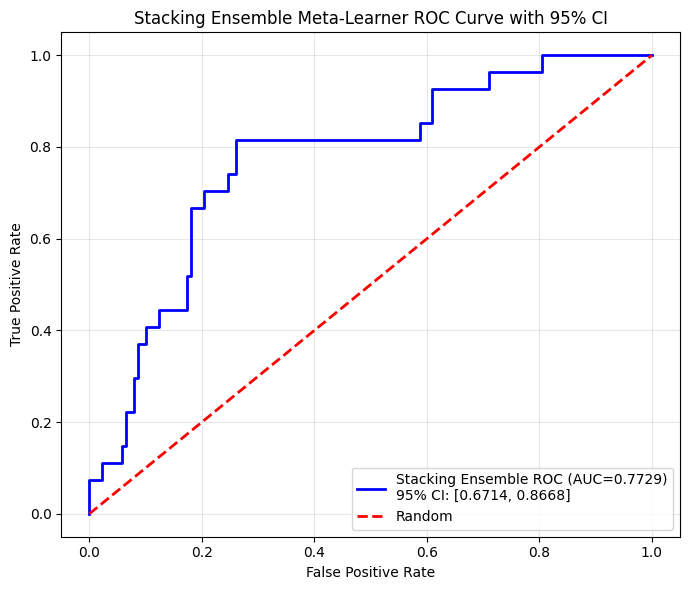

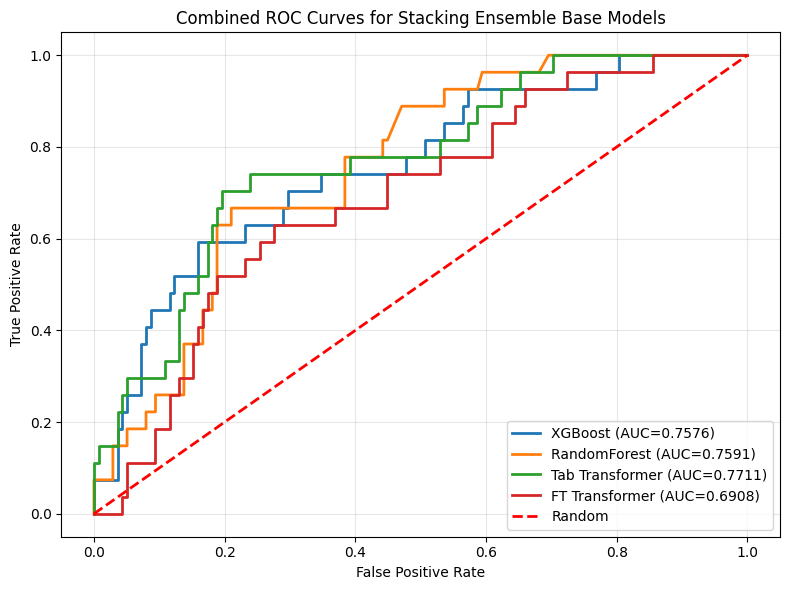

In [8]:
# XGBoost, RandomForest
import xgboost as xgb

def manual_grid_search_xgb(X, y, param_grid, num_boost_round=1000, cv=3, early_stopping_rounds=10, seed=42):
    best_score = 0
    best_params = None
    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for learning_rate in param_grid['learning_rate']:
                params = {
                    'objective': 'binary:logistic',
                    'eval_metric': 'auc',
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'learning_rate': learning_rate,
                    'seed': seed,
                }
                dtrain = xgb.DMatrix(X, label=y)
                cv_results = xgb.cv(params,
                                    dtrain,
                                    num_boost_round=num_boost_round,
                                    nfold=cv,
                                    early_stopping_rounds=early_stopping_rounds,
                                    seed=seed,
                                    verbose_eval=False)
                current_auc = cv_results['test-auc-mean'].max()
                current_round = cv_results['test-auc-mean'].idxmax()
                if current_auc > best_score:
                    best_score = current_auc
                    best_params = params.copy()
                    best_params['n_estimators'] = current_round
    return best_params, best_score

xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}
best_xgb_params, best_xgb_score = manual_grid_search_xgb(X_train_res, y_train_res, xgb_param_grid, seed=seed)
print("Best XGBoost params (manual):", best_xgb_params, "with AUC:", best_xgb_score)
# 'n_estimators' 분리하여 전달
best_xgb_params_for_clf = best_xgb_params.copy()
n_estimators_value = best_xgb_params_for_clf.pop('n_estimators', 100)
best_xgb = XGBClassifier(**best_xgb_params_for_clf, n_estimators=n_estimators_value, random_state=seed, use_label_encoder=False)
best_xgb.fit(X_train_res, y_train_res)
xgb_val_pred_prob = best_xgb.predict_proba(X_val)[:, 1]
xgb_test_pred_prob = best_xgb.predict_proba(X_test)[:, 1]

# RandomForest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
rf_model = RandomForestClassifier(random_state=seed)
rf_grid = GridSearchCV(rf_model, rf_param_grid, scoring='roc_auc', cv=3, n_jobs=-1, verbose=1)
rf_grid.fit(X_train_res, y_train_res)
best_rf = rf_grid.best_estimator_
print("Best RandomForest params:", rf_grid.best_params_)
rf_val_pred_prob = best_rf.predict_proba(X_val)[:, 1]
rf_test_pred_prob = best_rf.predict_proba(X_test)[:, 1]

# Deep Learning DataLoader

X_train_tensor = torch.tensor(X_train_res, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_res, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Tab Transformer, FT Transformer

# (A) Tab Transformer
class TabTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim=32, num_heads=4, num_layers=2, dropout=0.1):
        """
        간단한 Tab Transformer: 입력 데이터를 embed_dim으로 매핑한 후 Transformer Encoder 적용
        """
        super(TabTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads,
                                                    dim_feedforward=embed_dim*4, dropout=dropout,
                                                    batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embed_dim, 1)
    def forward(self, x):
        x = self.embedding(x)           # (batch_size, embed_dim)
        x = x.unsqueeze(1)              # (batch_size, 1, embed_dim)
        x = self.transformer_encoder(x)
        x = x.squeeze(1)                # (batch_size, embed_dim)
        x = self.fc(x)                  # (batch_size, 1)
        return x

# (B) FT Transformer
class FTTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim=16, num_heads=2, num_layers=2, dropout=0.1):
        super(FTTransformer, self).__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, dropout=dropout,
                                                    batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        x = self.input_proj(x)
        x = x.unsqueeze(1)
        x = self.transformer_encoder(x)
        x = x.squeeze(1)
        x = self.fc(x)
        return x

# PyTorch Model

def train_deep_model(model, train_loader, val_loader, device, num_epochs=50):
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float("inf")
    best_state = None
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                val_outputs = model(X_val_batch)
                total_val_loss += criterion(val_outputs, y_val_batch).item()
        avg_val_loss = total_val_loss / len(val_loader)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_state = model.state_dict()
    model.load_state_dict(best_state)
    return model


# 6. hiperparameter Tuning (Grid Search)

from itertools import product

def tune_deep_model(model_class, param_grid, train_loader, val_loader, device, num_epochs=30):
    best_val_loss = float("inf")
    best_params = None
    best_model = None
    keys = list(param_grid.keys())
    for values in product(*[param_grid[k] for k in keys]):
        params = dict(zip(keys, values))
        print("Tuning with parameters:", params)
        model = model_class(input_dim=X_train_tensor.shape[1], **params)
        model = train_deep_model(model, train_loader, val_loader, device, num_epochs=num_epochs)
        model.eval()
        total_val_loss = 0
        criterion = nn.BCEWithLogitsLoss()
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                outputs = model(X_val_batch)
                total_val_loss += criterion(outputs, y_val_batch).item()
        avg_val_loss = total_val_loss / len(val_loader)
        print("Validation loss:", avg_val_loss)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_params = params
            best_model = model
    print("Best deep model parameters:", best_params, "with validation loss:", best_val_loss)
    return best_model, best_params

# Tab Transformer Tuning
tabtrans_param_grid = {
    'embed_dim': [32, 64],
    'num_heads': [2, 4],
    'num_layers': [2, 3],
    'dropout': [0.1, 0.3]
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\n--- Tuning Tab Transformer ---")
best_tabtrans_model, best_tabtrans_params = tune_deep_model(TabTransformer, tabtrans_param_grid, train_loader, val_loader, device, num_epochs=30)

# FT Transformer Tuning
fttrans_param_grid = {
    'hidden_dim': [16, 32],
    'num_heads': [2, 4],
    'num_layers': [2, 3],
    'dropout': [0.1, 0.3]
}
print("\n--- Tuning FT Transformer ---")
best_fttrans_model, best_fttrans_params = tune_deep_model(FTTransformer, fttrans_param_grid, train_loader, val_loader, device, num_epochs=30)


# evaluation

def get_deep_model_predictions(model, loader, device):
    model.eval()
    y_pred_prob = []
    with torch.no_grad():
        for X_batch, _ in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            y_pred_prob.extend(probs)
    y_pred_prob = np.array(y_pred_prob)
    y_pred = (y_pred_prob >= 0.5).astype(int)
    return y_pred_prob, y_pred

# (A) Tab Transformer
y_pred_prob_tabtrans, y_pred_tabtrans = get_deep_model_predictions(best_tabtrans_model, test_loader, device)
# (B) FT Transformer
y_pred_prob_fttrans, y_pred_fttrans = get_deep_model_predictions(best_fttrans_model, test_loader, device)


# 8. Stacking Ensemble: ML Model (XGBoost, RandomForest) & DL Model (Tab Transformer, FT Transformer)

# Meta feature 생성을 위해 Validation 세트에서 예측 확률 추출
xgb_val_pred_prob = best_xgb.predict_proba(X_val)[:, 1]
rf_val_pred_prob = best_rf.predict_proba(X_val)[:, 1]
def get_deep_preds(loader, model, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for X_batch, _ in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds.extend(torch.sigmoid(outputs).cpu().numpy().flatten())
    return np.array(preds)

tabtrans_val_pred_prob = get_deep_preds(val_loader, best_tabtrans_model, device)
fttrans_val_pred_prob = get_deep_preds(val_loader, best_fttrans_model, device)

# Meta feature 행렬 (Validation set)
meta_val = np.column_stack([xgb_val_pred_prob, rf_val_pred_prob, tabtrans_val_pred_prob, fttrans_val_pred_prob])
meta_y_val = y_val

# Meta-learner (Logistic Regression) 학습
meta_learner = LogisticRegression(random_state=seed, class_weight='balanced')
meta_learner.fit(meta_val, meta_y_val)

# 최종 테스트 세트 meta feature 생성
xgb_test_pred_prob = best_xgb.predict_proba(X_test)[:, 1]
rf_test_pred_prob = best_rf.predict_proba(X_test)[:, 1]
tabtrans_test_pred_prob, _ = get_deep_model_predictions(best_tabtrans_model, test_loader, device)
fttrans_test_pred_prob, _ = get_deep_model_predictions(best_fttrans_model, test_loader, device)
meta_test = np.column_stack([xgb_test_pred_prob, rf_test_pred_prob, tabtrans_test_pred_prob, fttrans_test_pred_prob])

# Meta-learner를 이용한 최종 예측 (Meta probabilities)
meta_test_pred_prob = meta_learner.predict_proba(meta_test)[:, 1]

# 임계값 튜닝: meta-validation set에서 F1 score 최대값을 주는 임계치를 선택
meta_val_pred_prob = meta_learner.predict_proba(meta_val)[:, 1]
from sklearn.metrics import f1_score
thresholds = np.linspace(0.0, 1.0, 101)
best_thresh = 0.5
best_f1 = 0
for t in thresholds:
    preds = (meta_val_pred_prob >= t).astype(int)
    f1 = f1_score(meta_y_val, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t
print("Best threshold on meta-validation (F1):", best_thresh, "with F1 score:", best_f1)

# 최종 meta test 예측 적용
meta_test_pred = (meta_test_pred_prob >= best_thresh).astype(int)

meta_acc = accuracy_score(y_test, meta_test_pred)
meta_auc = roc_auc_score(y_test, meta_test_pred_prob)
print("\n--- Stacking Ensemble Meta-Learner ---")
print("Meta-Learner Accuracy:", meta_acc)
print("Meta-Learner AUC:", meta_auc)
print("Meta-Learner Classification Report:\n", classification_report(y_test, meta_test_pred))
print("Meta-Learner Confusion Matrix:\n", confusion_matrix(y_test, meta_test_pred))


# 부트스트랩을 통한 AUROC 95% CI 및 ROC Curve 시각화 (Stacking Ensemble)

def bootstrap_auc_ci(y_true, y_pred_prob, n_bootstraps=1000, seed=42):
    rng = np.random.RandomState(seed)
    bootstrapped_scores = []
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_pred_prob), len(y_pred_prob))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_pred_prob[indices])
        bootstrapped_scores.append(score)
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    lower = sorted_scores[int(0.025 * len(sorted_scores))]
    upper = sorted_scores[int(0.975 * len(sorted_scores))]
    return lower, upper

lower, upper = bootstrap_auc_ci(y_test, meta_test_pred_prob, n_bootstraps=1000, seed=seed)
fpr_meta, tpr_meta, _ = roc_curve(y_test, meta_test_pred_prob)

plt.figure(figsize=(7,6))
plt.plot(fpr_meta, tpr_meta, color='blue', lw=2,
         label=f'Stacking Ensemble ROC (AUC={meta_auc:.4f})\n95% CI: [{lower:.4f}, {upper:.4f}]')
plt.plot([0,1], [0,1], color='red', lw=2, linestyle='--', label='Random')
plt.title('Stacking Ensemble Meta-Learner ROC Curve with 95% CI')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# Combined ROC Curve: 4 모델 개별 ROC Curve 시각화 (Stacking Ensemble Base Models)

plt.figure(figsize=(8,6))

# XGBoost ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_test_pred_prob)
auc_xgb = roc_auc_score(y_test, xgb_test_pred_prob)
plt.plot(fpr_xgb, tpr_xgb, lw=2, label=f'XGBoost (AUC={auc_xgb:.4f})')

# RandomForest ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_test_pred_prob)
auc_rf = roc_auc_score(y_test, rf_test_pred_prob)
plt.plot(fpr_rf, tpr_rf, lw=2, label=f'RandomForest (AUC={auc_rf:.4f})')

# Tab Transformer ROC
fpr_tab, tpr_tab, _ = roc_curve(y_test, tabtrans_test_pred_prob)
auc_tab = roc_auc_score(y_test, tabtrans_test_pred_prob)
plt.plot(fpr_tab, tpr_tab, lw=2, label=f'Tab Transformer (AUC={auc_tab:.4f})')

# FT Transformer ROC
fpr_ft, tpr_ft, _ = roc_curve(y_test, fttrans_test_pred_prob)
auc_ft = roc_auc_score(y_test, fttrans_test_pred_prob)
plt.plot(fpr_ft, tpr_ft, lw=2, label=f'FT Transformer (AUC={auc_ft:.4f})')

plt.plot([0,1], [0,1], color='red', lw=2, linestyle='--', label='Random')
plt.title("Combined ROC Curves for Stacking Ensemble Base Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()